# Classifying Tumors in Mammograms

# Part 2B - DDSM Modeling & Conclusions

## Contents
- [References](#References)
- [Data Import & Cleaning](#Data-Import-&-Cleaning)
    - [Final Validation Dataset for After Modeling](#Final-Validation-Dataset-for-After-Modeling)
    - [Training Data for Modeling](#Training-Data-for-Modeling)
- [Modeling](#Modeling)
    - [Baseline](#Baseline)
    - [CNN 1](#CNN-1)
    - [CNN 2](#CNN-2)
- [Conclusions & Recommendations](#Conclusions-&-Recommendations)

## References
1. MIAS Data Source: http://peipa.essex.ac.uk/info/mias.html
2. DDSM Data Source: https://www.kaggle.com/skooch/ddsm-mammography
3. CBIS-DDSM Data Source (EDA): https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM
3. https://www.kaggle.com/kmader/mias-mammography
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5954872/
5. https://pubmed.ncbi.nlm.nih.gov/24209932/
6. https://core.ac.uk/download/pdf/21748057.pdf
7. https://www.nature.com/articles/sdata2017177

## Data Import & Cleaning

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import glob
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from colorama import Fore, Back, Style
from mpl_toolkits.axes_grid1 import ImageGrid
import random

In [216]:
tf.random.set_seed(1234)

In [217]:
images=[]
labels=[]

feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

dataset_dir = './data/ddsm/'

In [218]:
# Functions for Training data

def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299,1])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        #image=cv2.resize(image,(299,299))
        #image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

In [219]:
filenames=[f'{dataset_dir}/archive/training10_0/training10_0.tfrecords',
          f'{dataset_dir}/archive/training10_1/training10_1.tfrecords',
          f'{dataset_dir}/archive/training10_2/training10_2.tfrecords',
          f'{dataset_dir}/archive/training10_3/training10_3.tfrecords',
          f'{dataset_dir}/archive/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
55885
55885


## Final Validation Dataset for After Modeling

In [220]:
# Per instructions, we need to combine both the val and test sets due to a parsing error during creation

test_data = np.concatenate((np.load(f'{dataset_dir}/archive/cv10_data/cv10_data.npy'), 
                            np.load(f'{dataset_dir}/archive/test10_data/test10_data.npy')))        
test_labels = np.concatenate((np.load(f'{dataset_dir}/archive/cv10_labels.npy'), 
                              np.load(f'{dataset_dir}/archive/test10_labels.npy')))
                      
test_labels = np.where(test_labels==0, 0, test_labels)
test_labels = np.where(test_labels!=0, 1, test_labels)

sizeit = []
for i in np.arange(test_data.shape[0]):
    mytemp=cv2.resize(test_data[i,:,:,:],(100,100))
    sizeit.append(mytemp)

test_data = np.asarray(sizeit)
(a,b,c)=test_data.shape 
test_data = np.reshape(test_data, (a, b, c, 1))

test_data.shape, test_labels.shape

((15364, 100, 100, 1), (15364,))

## Training Data for Modeling

In [221]:
# Setting up X and y and train test split

X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True,stratify=y)
(a,b,c)=x_train.shape 
x_train = np.reshape(x_train, (a, b, c, 1))
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))

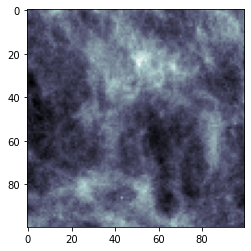

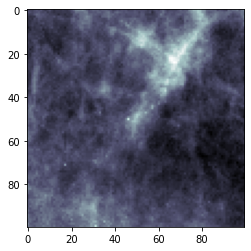

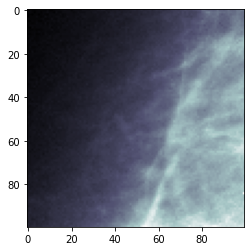

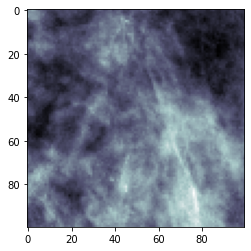

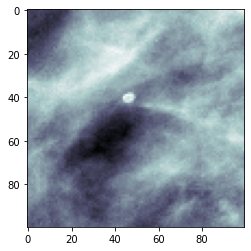

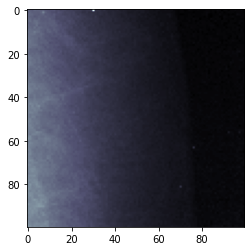

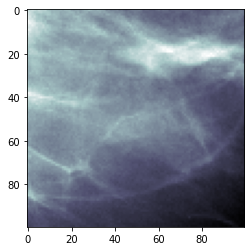

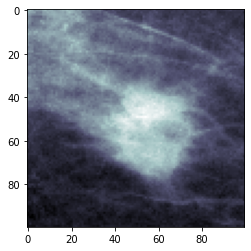

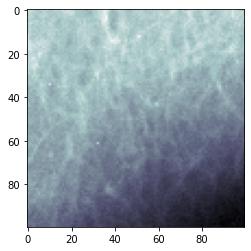

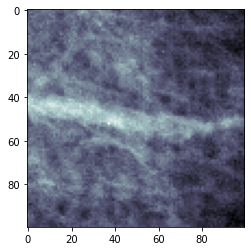

In [222]:
# Check first 10 images
for i in range(10):
    plt.imshow(x_train[i],cmap=plt.get_cmap('bone'))
    plt.show()

In [223]:
print(x_train[0].shape)

(100, 100, 1)


In [224]:
x_train.shape,y_train.shape

((44708, 100, 100, 1), (44708,))

## Baseline

In [225]:
df_labels = pd.DataFrame(labels)
df_labels.value_counts(normalize = True)

0    0.869571
1    0.130429
dtype: float64

## CNN 1

In [77]:
rows, cols,color = x_train[0].shape
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='valid', strides=(1, 1),input_shape=(rows,cols,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 49, 49, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)       

In [78]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2,shuffle=True, epochs=40, batch_size=64,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('Test_accuracy = ' + str(accuracy))

Epoch 1/40
559/559 [==============================] - 194s 346ms/step - loss: 0.5068 - accuracy: 0.8645 - val_loss: 0.3811 - val_accuracy: 0.8668
Epoch 2/40
559/559 [==============================] - 226s 404ms/step - loss: 0.3256 - accuracy: 0.8787 - val_loss: 0.3063 - val_accuracy: 0.8870
Epoch 3/40
559/559 [==============================] - 218s 390ms/step - loss: 0.2723 - accuracy: 0.8901 - val_loss: 0.2661 - val_accuracy: 0.8950
Epoch 4/40
559/559 [==============================] - 222s 397ms/step - loss: 0.2494 - accuracy: 0.8980 - val_loss: 0.2534 - val_accuracy: 0.8977
Epoch 5/40
559/559 [==============================] - 212s 379ms/step - loss: 0.2388 - accuracy: 0.9003 - val_loss: 0.2262 - val_accuracy: 0.8988
Epoch 6/40
559/559 [==============================] - 210s 375ms/step - loss: 0.2309 - accuracy: 0.9043 - val_loss: 0.2198 - val_accuracy: 0.9109
Epoch 7/40
559/559 [==============================] - 218s 389ms/step - loss: 0.2214 - accuracy: 0.9082 - val_loss: 0.2108 -

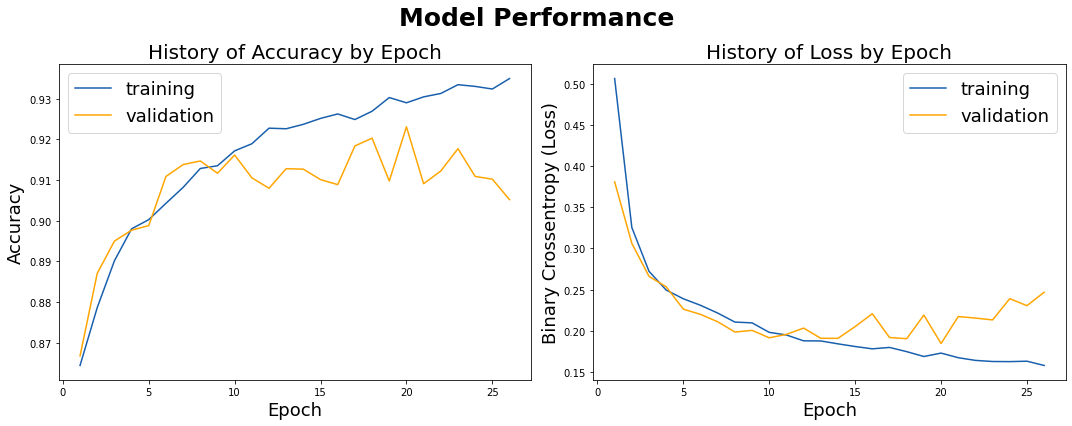

In [81]:
# Helper Function for checking out our train loss and test loss over epochs

def Loss_Acc_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
    fig.suptitle("Model Performance", fontsize = 25, fontweight = 'bold')
    fig.savefig('Accuracy_Loss_figure.png')

    ax1.plot(range(1, len(acc) + 1), acc,  color='#185fad')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, color='orange')
    ax1.set_title('History of Accuracy by Epoch', fontsize=20)
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Accuracy', fontsize=18)
    ax1.legend(['training', 'validation'], fontsize=18)


    ax2.plot(range(1, len(loss) + 1), loss, color='#185fad')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, color='orange')
    ax2.set_title('History of Loss by Epoch', fontsize=20)
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Binary Crossentropy (Loss)', fontsize=18)
    ax2.legend(['training', 'validation'], fontsize=18)
    
    plt.tight_layout()
    plt.show()
    
Loss_Acc_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [86]:
y_pred=model.predict_classes(x_test)
y_pred_prob=model.predict_proba(x_test)

In [87]:
target=['0', '1']

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.9222
Precision: 0.9182
Recall: 0.9222
F1 Score: 0.9126
ROC AUC Score: 0.9526
		Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      9719
           1       0.86      0.48      0.62      1458

    accuracy                           0.92     11177
   macro avg       0.89      0.74      0.79     11177
weighted avg       0.92      0.92      0.91     11177



In [213]:
cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=2)
#cm = confusion_matrix(y_test, y_pred).astype("int32")
cm_df = pd.DataFrame(matrix, columns=['pred no tumor', 'pred tumor'], index=['actual no tumor', 'actual tumor'])
cm_df

,pred no tumor,pred tumor
actual no tumor,9601,118
actual tumor,752,706


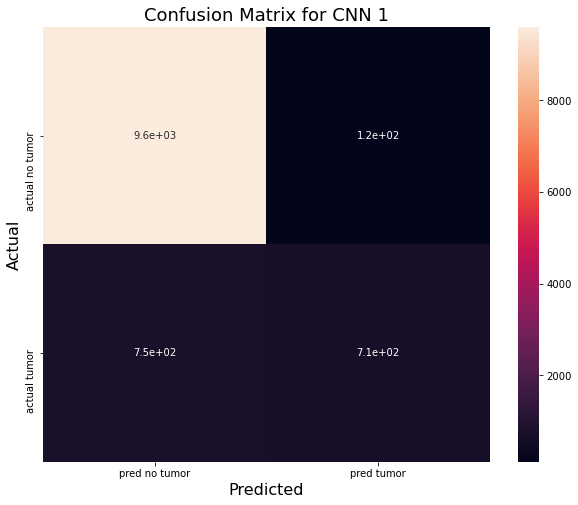

In [222]:
# Plot confusion matrix

plt.figure(figsize=(10,8))
f = sns.heatmap(cm_df, annot=True, 
                #fmt="d"
               )
plt.xlabel('Predicted', size = 16)
plt.ylabel('Actual', size = 16)
plt.title('Confusion Matrix for CNN 1', size = 18);

In [127]:
# Getting predictions on Test dataset

test_pred=model.predict_classes(test_data)
test_pred_prob=model.predict_proba(test_data)

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [128]:
# Test Dataset results

target=['0', '1']
print('Accuracy:', np.round(metrics.accuracy_score(test_labels, test_pred),4))
print('Precision:', np.round(metrics.precision_score(test_labels, test_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_labels,test_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_labels, test_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(test_labels, test_pred_prob,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(test_labels, test_pred,target_names=target))

Accuracy: 0.9313
Precision: 0.9288
Recall: 0.9313
F1 Score: 0.9241
ROC AUC Score: 0.9632
		Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96     13360
           1       0.89      0.54      0.67      2004

    accuracy                           0.93     15364
   macro avg       0.91      0.77      0.82     15364
weighted avg       0.93      0.93      0.92     15364



In [89]:
model.save('./models/breast_cancer_model.h1')

INFO:tensorflow:Assets written to: ./models/breast_cancer_model.h1/assets


## CNN 2

In [250]:
rows, cols,color = x_train[0].shape
model = Sequential()

model.add(Conv2D(32, (3, 3),input_shape=(rows,cols,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 10, 10, 64)      

In [251]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_data = (x_test, y_test), epochs=50, batch_size=64, callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('Test_accuracy = ' + str(accuracy))

Epoch 1/50
699/699 [==============================] - 204s 292ms/step - loss: 0.4131 - accuracy: 0.8680 - val_loss: 0.3141 - val_accuracy: 0.8695
Epoch 2/50
699/699 [==============================] - 198s 283ms/step - loss: 0.2920 - accuracy: 0.8825 - val_loss: 0.3040 - val_accuracy: 0.8741
Epoch 3/50
699/699 [==============================] - 199s 285ms/step - loss: 0.2644 - accuracy: 0.8887 - val_loss: 0.3129 - val_accuracy: 0.8773
Epoch 4/50
699/699 [==============================] - 195s 280ms/step - loss: 0.2467 - accuracy: 0.8963 - val_loss: 0.2325 - val_accuracy: 0.8953
Epoch 5/50
699/699 [==============================] - 197s 282ms/step - loss: 0.2372 - accuracy: 0.9001 - val_loss: 0.2785 - val_accuracy: 0.8917
Epoch 6/50
699/699 [==============================] - 198s 283ms/step - loss: 0.2306 - accuracy: 0.9037 - val_loss: 0.2361 - val_accuracy: 0.8959
Epoch 7/50
699/699 [==============================] - 221s 316ms/step - loss: 0.2258 - accuracy: 0.9048 - val_loss: 0.2651 -

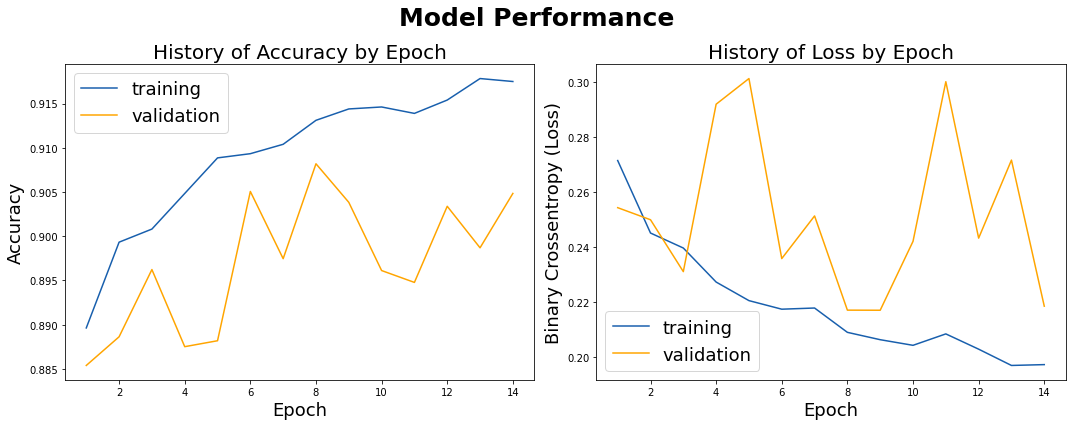

In [227]:
Loss_Acc_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [233]:
y_pred=model.predict_classes(x_test)
y_pred_prob=model.predict_proba(x_test)

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [236]:
target=['0', '1']

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.9056
Precision: 0.9046
Recall: 0.9056
F1 Score: 0.8851
ROC AUC Score: 0.9526
		Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      9719
           1       0.89      0.31      0.46      1458

    accuracy                           0.91     11177
   macro avg       0.90      0.65      0.71     11177
weighted avg       0.90      0.91      0.89     11177



In [234]:
#cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=2)
cm = confusion_matrix(y_test, y_pred).astype("int32")
cm_df = pd.DataFrame(cm , columns=['pred no tumor', 'pred tumor'], index=['actual no tumor', 'actual tumor'])
cm_df

,pred no tumor,pred tumor
actual no tumor,9665,54
actual tumor,1001,457


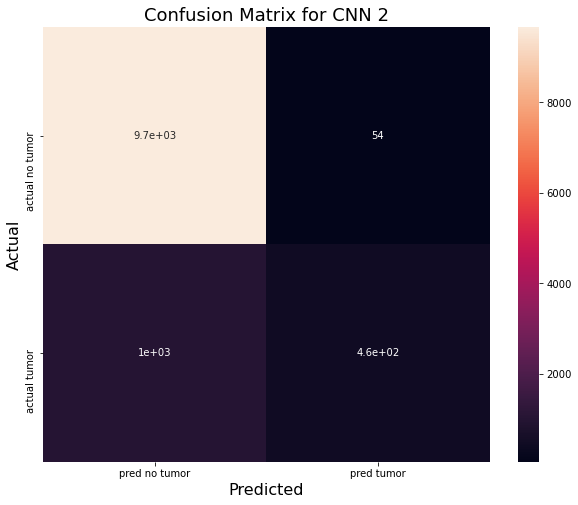

In [235]:
# Plot confusion matrix

plt.figure(figsize=(10,8))
f = sns.heatmap(cm_df, annot=True)
plt.xlabel('Predicted', size = 16)
plt.ylabel('Actual', size = 16)
plt.title('Confusion Matrix for CNN 2', size = 18);

In [238]:
# Getting predictions on Test dataset

test_pred=model.predict_classes(test_data)
test_pred_prob=model.predict_proba(test_data)

/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/Users/emilysiegel/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [239]:
# Test Dataset results

target=['0', '1']
print('Accuracy:', np.round(metrics.accuracy_score(test_labels, test_pred),4))
print('Precision:', np.round(metrics.precision_score(test_labels, test_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_labels,test_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_labels, test_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(test_labels, test_pred_prob,multi_class='ovo', average='weighted'),4))
print('\t\tClassification Report:\n', metrics.classification_report(test_labels, test_pred,target_names=target))

Accuracy: 0.9107
Precision: 0.912
Recall: 0.9107
F1 Score: 0.8922
ROC AUC Score: 0.9479
		Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     13360
           1       0.93      0.34      0.50      2004

    accuracy                           0.91     15364
   macro avg       0.92      0.67      0.73     15364
weighted avg       0.91      0.91      0.89     15364



In [237]:
model.save('./models/breast_cancer_model.h2')

INFO:tensorflow:Assets written to: ./models/breast_cancer_model.h2/assets


## Conclusions & Recommendations

- Beat Baseline with 92-93% accuracy on Test and Validation datasets
- More training data & using processed cropped images seem to be key
- More complex networks and using the full 299x299 resolution did not improve results and slowed down training
- Would love more insight into the preprocessing of the DDSM Cropped Images to better insure there is no data leakage in the dataset. Given more time, I think we would use the original full breast mammogram images and do our own image preprocessing and data augmentation on them before modeling. 
- Image classification and Deep Learning models can be VERY resource intensive and computationally expensive

